# Importing Relevant Libraries

In [ ]:
#installing & importing libraries

# !pip install torch
# !pip install opencv-python
# !pip install torch torchvision

import os
from PIL import Image
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import cv2
# import sys
print("done")

done


In [2]:
# setting the random values as static for reproducibility
random_seed = 42;
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
# # My list of class names
# class_names = [
#     "Banku", "Banku_and_pepper", "Banku_and_soup", "Beans and Plantain", "boiled yam",
#     "fried rice", "fufu", "jollof", "plainrice", "rice and stew","waakye"]

# Food Image Dataset

In [4]:
class FoodImagesDataset:
    """Custom dataset for food images."""
    def __init__(self, root="./data", batch_size=64, resize=(28, 28)):
        self.root = root
        self.batch_size = batch_size
        self.resize = resize
        self.trans = transforms.Compose([
            transforms.Resize(self.resize),
            transforms.ToTensor()
        ])
        self.train = torchvision.datasets.ImageFolder(
            root=self.root + "/food_images_train", transform=self.trans)
        self.val = torchvision.datasets.ImageFolder(
            root=self.root + "/food_images_val", transform=self.trans)
        
    def __len__(self):
        return len(self.train)

data_set = FoodImagesDataset(root="./", resize=(32, 32))
print("Training images: " + str(len(data_set.train)))
print("Validation images: " + str(len(data_set.val)))

Training images: 612
Validation images: 110


# Neural Network Model

In [5]:
# Loading the training dataset to get class names
train_dataset = datasets.ImageFolder(root='food_images_train', transform=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

]))

# Get class names from the training dataset
class_names = train_dataset.classes
print(f"Class names: {class_names}")

Class names: ['banku', 'banku_and_pepper', 'banku_and_soup', 'beans_and_plantain', 'boiled_yam', 'fried_rice', 'fufu', 'jollof', 'plain_rice', 'rice_and_stew', 'waakye']


In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 12) 

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Parameters

In [7]:
# Initializing my model
model = MyModel()

# Defining my loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Creating my data loaders
batch_size = 32
train_loader = DataLoader(data_set.train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_set.val, batch_size=batch_size, shuffle=False)

#defining my number of epochs
num_epochs = 40

# Training & Validation

In [8]:
# Training loop
start_time = time.time() #time the training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# End timing
end_time = time.time()

# Calculate the total time 
total_time = end_time - start_time
print(f'Finished Training in {total_time:.2f} seconds')

Epoch [1/40], Loss: 2.4633
Epoch [2/40], Loss: 2.3806
Epoch [3/40], Loss: 2.3733
Epoch [4/40], Loss: 2.3311
Epoch [5/40], Loss: 2.2379
Epoch [6/40], Loss: 2.0601
Epoch [7/40], Loss: 2.0273
Epoch [8/40], Loss: 1.9179
Epoch [9/40], Loss: 1.8916
Epoch [10/40], Loss: 1.8441
Epoch [11/40], Loss: 1.7548
Epoch [12/40], Loss: 1.6983
Epoch [13/40], Loss: 1.6230
Epoch [14/40], Loss: 1.6834
Epoch [15/40], Loss: 1.4931
Epoch [16/40], Loss: 1.3664
Epoch [17/40], Loss: 1.3444
Epoch [18/40], Loss: 1.2694
Epoch [19/40], Loss: 1.0702
Epoch [20/40], Loss: 0.9947
Epoch [21/40], Loss: 1.0431
Epoch [22/40], Loss: 0.8403
Epoch [23/40], Loss: 0.8409
Epoch [24/40], Loss: 0.7386
Epoch [25/40], Loss: 0.6714
Epoch [26/40], Loss: 0.6382
Epoch [27/40], Loss: 0.5654
Epoch [28/40], Loss: 0.5112
Epoch [29/40], Loss: 0.5340
Epoch [30/40], Loss: 0.4386
Epoch [31/40], Loss: 0.3446
Epoch [32/40], Loss: 0.2338
Epoch [33/40], Loss: 0.2055
Epoch [34/40], Loss: 0.1882
Epoch [35/40], Loss: 0.1219
Epoch [36/40], Loss: 0.0699
E

In [9]:
# Validation loop
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 98.18%


# Evaluate performance on validation set

In [10]:
def get_all_predictions_and_labels(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels


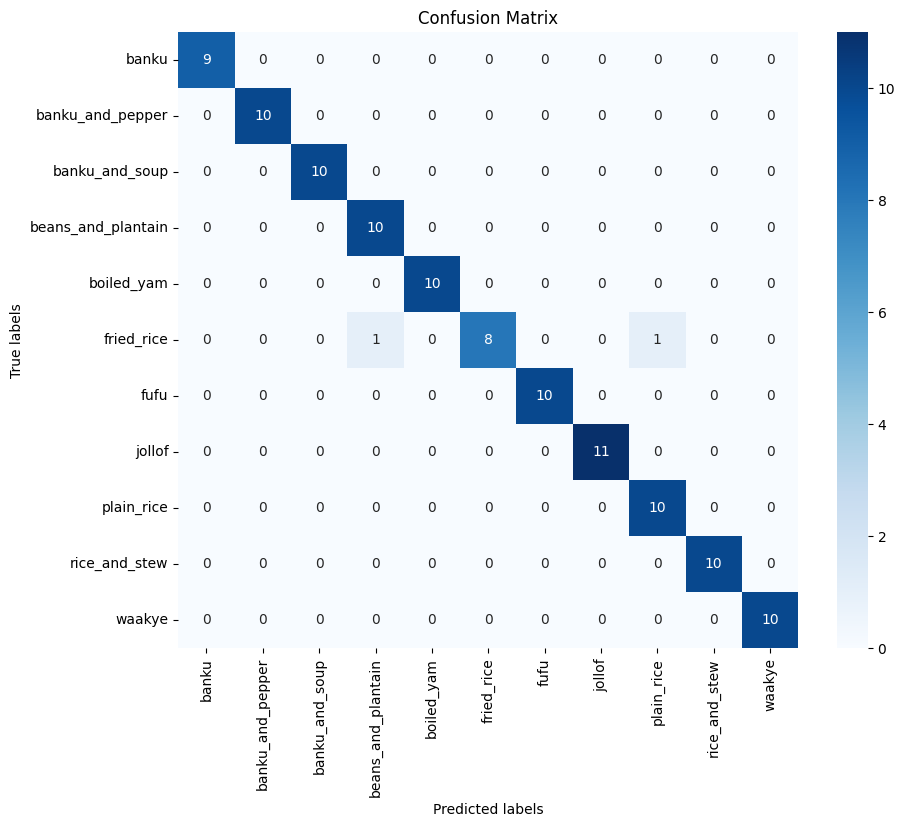

In [11]:
#confusion matrix on validation set
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

all_predictions, all_labels = get_all_predictions_and_labels(model, val_loader)

cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

# Predicting From a Directory

In [12]:
#function to make predictions on the test set
def predict_labels_with_filenames(model, image_folder, transform):
    predictions = []
    image_files = os.listdir(image_folder)
    predictions_dict = {}
    
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        
        if os.path.isdir(img_path):
            print(f"Skipping directory: {img_path}")
            continue
        
        try:
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0)  # Add batch dimension
            
            with torch.no_grad():
                output = model(image)
            
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
            predicted_class_name = class_names[predicted_label]
            
            predictions_dict[img_file] = {
                'predicted_label': predicted_label,
                'predicted_class_name': predicted_class_name
            }
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    return predictions_dict

In [13]:
# images to be labelled
image_folder = "food_images_test"

# image transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

model.eval()

predictions_with_filenames = predict_labels_with_filenames(model, image_folder, transform)

# Displaying the predictions
for img_file, info in predictions_with_filenames.items():
    print(f"Image: {img_file}, Predicted Label: {info['predicted_label']}, Class Name: {info['predicted_class_name']}")

Image: randomim.jpg, Predicted Label: 10, Class Name: waakye
Image: 56.jpeg, Predicted Label: 2, Class Name: banku_and_soup
Image: 34.jpeg, Predicted Label: 2, Class Name: banku_and_soup
Image: 4.jpeg, Predicted Label: 3, Class Name: beans_and_plantain
Image: image.jpeg, Predicted Label: 7, Class Name: jollof
Image: 2.jpeg, Predicted Label: 0, Class Name: banku
Image: 44.png, Predicted Label: 7, Class Name: jollof


# Predicting the Captured Image

In [14]:
#predict from an input image and save prediction to a file
def predict_saved():
    image_folder = "./Capstone_App/new_images"
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    
    model.eval()
    
    predictions_with_filenames = predict_labels_with_filenames(model, image_folder, transform)
    
    # Display the predictions
    for img_file, info in predictions_with_filenames.items():
        print(f"Image: {img_file}, Predicted Label: {info['predicted_label']}, Class Name: {info['predicted_class_name']}")
    
    # write the prediction to a file
    text = "\n".join([f"Image: {img_file}, Predicted Label: {info['predicted_label']}, Class Name: {info['predicted_class_name']}" for img_file, info in predictions_with_filenames.items()])
    file_path = "./Capstone_App/output.txt"
    with open(file_path, 'w') as file:
        file.write(text)
    
    print(f"Text has been written to {file_path}")

predict_saved()



Error processing ./Capstone_App/new_images/.DS_Store: cannot identify image file './Capstone_App/new_images/.DS_Store'
Text has been written to ./Capstone_App/output.txt
